# **1. Loading data and Checking ARIMA assumptions for Fenyuan 2F**

Condition 1: Data Should be univariate-This condition is satisfied because we are considering only one orbital element that is, Brouwer Mean Motion

Condition 2: Are there any missing values in the data?

In [ ]:

# !pip uninstall -y numpy scipy statsmodels pmdarima


# !pip install numpy==1.25.2 scipy==1.11.4 statsmodels==0.14.0 pmdarima==2.0.4


In [ ]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import numpy as np



In [ ]:
# Load data
df = pd.read_csv('/content/Fengyun-2F.csv')
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('timestamp', inplace=True)

# Check missing values
df['Brouwer mean motion'].isnull().sum()


0

Condition 3: Time Intervals should be regular



In [ ]:
time_deltas = df.index.to_series().diff().value_counts()
print(time_deltas.head())


timestamp
1 days 00:07:15.943296    2
1 days 04:08:10.112064    1
0 days 19:00:41.377248    1
0 days 23:29:32.899201    1
2 days 08:51:25.546751    1
Name: count, dtype: int64


As we can see from the output. The condition is not met. We are fixing this using interpolation

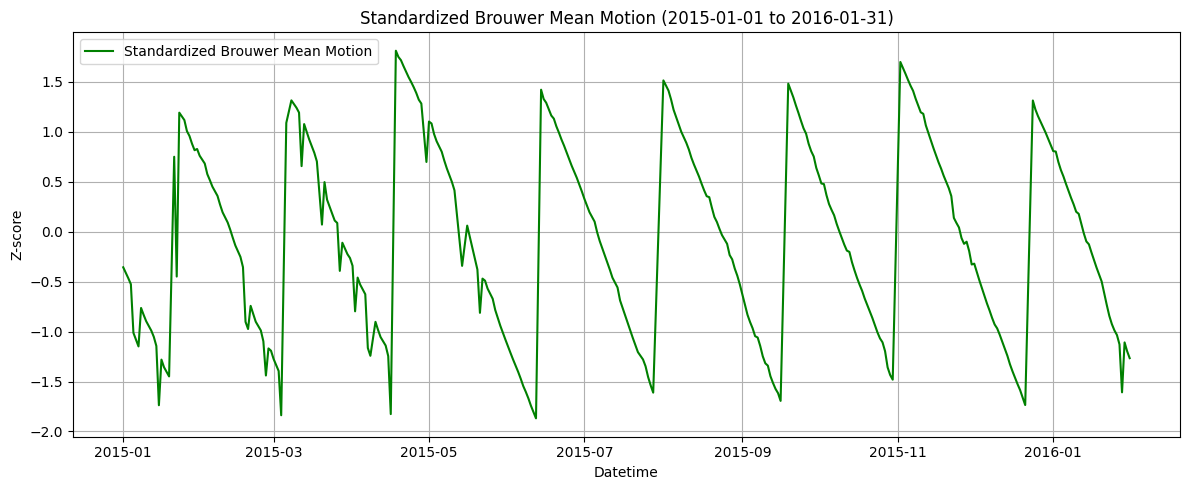

In [ ]:
#Parse the timestamp column
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('timestamp', inplace=True)

#Select the 'Brouwer mean motion' column
bmm_series = df['Brouwer mean motion']

#Step: Resampling
bmm_resampled = bmm_series.resample('D').mean()

#Using Linear Interpolation to fill the gaps
bmm_interpolated = bmm_resampled.interpolate(method='linear')

# Go back to full standardization
bmm_standardized = (bmm_interpolated-bmm_interpolated.mean())/bmm_interpolated.std()


# STEP 8: Define time window
start_date = '2015-01-01'
end_date = '2016-01-31'

# STEP 9: Filter standardized data
standardized_window = bmm_standardized[start_date:end_date]

# STEP 10: Plot only standardized data
plt.figure(figsize=(12, 5))
plt.plot(standardized_window, label='Standardized Brouwer Mean Motion', color='green')
plt.title(f'Standardized Brouwer Mean Motion ({start_date} to {end_date})')
plt.xlabel('Datetime')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Condition 4: The data should be stationery. For ARIMA it is necessary that mean and variance are consistent  over time (meaning they dont have any trend, seasonality and changing variance)

In [ ]:
# Checking through ADF- Statistical Test
from statsmodels.tsa.stattools import adfuller

# Run ADF Test
result = adfuller(bmm_standardized.dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("✅ The series is stationary (p < 0.05)")
else:
    print("❌ The series is NOT stationary (p ≥ 0.05)")


ADF Statistic: -18.72055335447348
p-value: 2.032774752880195e-30
✅ The series is stationary (p < 0.05)


In [ ]:
# Perform ADF test on the standardized series
adf_result = adfuller(bmm_standardized.dropna())  # Drop NaNs to avoid issues

# Print ADF test results
print("\nAugmented Dickey-Fuller Test Results:")
print(f"ADF Statistic      : {adf_result[0]}")
print(f"p-value            : {adf_result[1]}")
print(f"# Lags Used        : {adf_result[2]}")
print(f"# Observations Used: {adf_result[3]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# STEP 13: Conclusion based on p-value
alpha = 0.05
if adf_result[1] < alpha:
    print("\n✅ Conclusion: The time series is likely **stationary** (reject H₀).")
else:
    print("\n❌ Conclusion: The time series is likely **non-stationary** (fail to reject H₀).")



Augmented Dickey-Fuller Test Results:
ADF Statistic      : -18.72055335447348
p-value            : 2.032774752880195e-30
# Lags Used        : 30
# Observations Used: 3384
Critical Values:
   1%: -3.432283885147278
   5%: -2.8623944783328996
   10%: -2.5672248552253967

✅ Conclusion: The time series is likely **stationary** (reject H₀).


Condition 5: Choose d,p,q values

Since our data is already stationery, we choose d=0

Choosing p and q using 'auto_arima'

In [ ]:
!pip install pmdarima


In [ ]:
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings("ignore")

# Input series (already standardised and interpolated)
series_for_arima = bmm_standardized.dropna()

# 🔍 Automatically determine best ARIMA(p,d,q) using full search
model_auto = auto_arima(
    series_for_arima,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,
    seasonal=False,
    stepwise=False,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)

print("\n✅ Best ARIMA model selected by auto_arima:")
print(model_auto.summary())


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9692.350, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6656.135, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5230.504, Time=2.69 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4568.673, Time=0.98 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4202.232, Time=1.34 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=3991.271, Time=2.54 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3751.252, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3669.202, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3665.664, Time=0.92 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3663.300, Time=1.78 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=3659.396, Time=2.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3662.678, Time=1.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3501.168, Time=3.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3477.437, Time=5.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3480.987, Time=7.00 sec
 ARIMA(3,0

Hence p=4, d=0, q=1

Condition 6: Residuals should be white noise

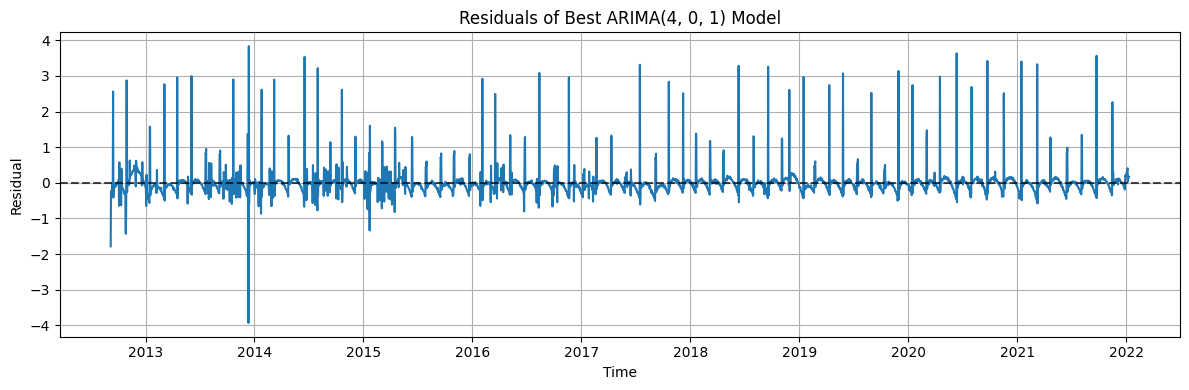

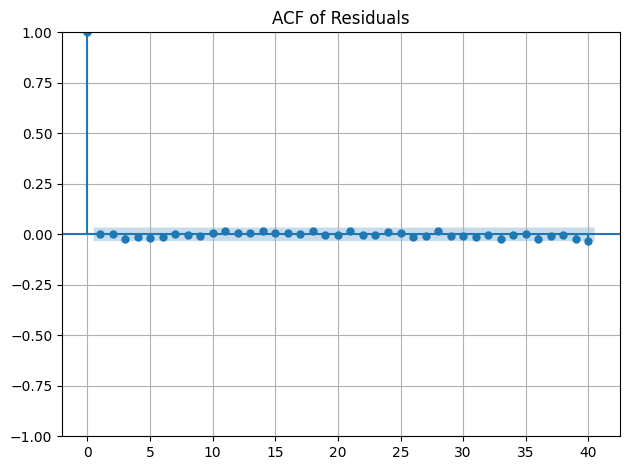

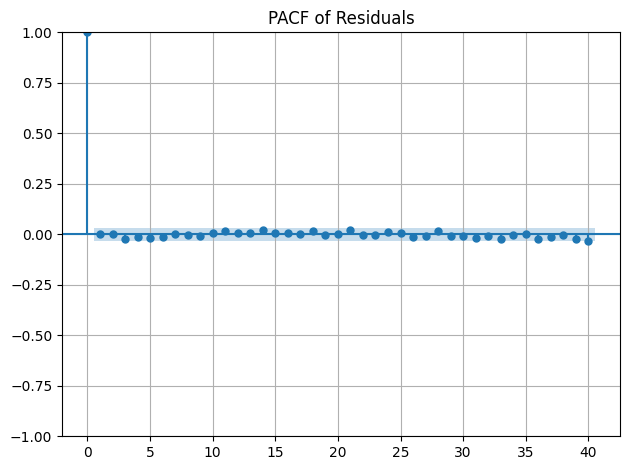

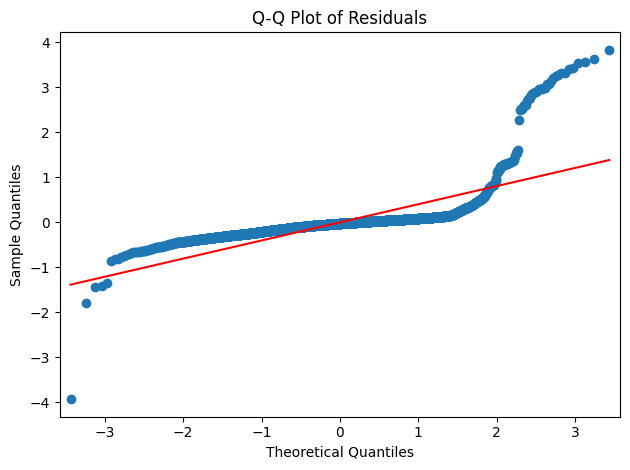


📊 Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   3.977041   0.948377
20   7.273723   0.995686
30  11.648319   0.998948

✅ Conclusion: Residuals resemble **white noise** (no significant autocorrelation).


In [ ]:
# Fit the selected model using statsmodels for residual analysis
best_params = model_auto.order
best_model = sm.tsa.ARIMA(series_for_arima, order=best_params).fit()

# Extract residuals
residuals = best_model.resid.dropna()

# 1. Residual time series plot
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f'Residuals of Best ARIMA{best_params} Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. ACF plot
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. PACF plot
plot_pacf(residuals, lags=40, method='ywm')
plt.title('PACF of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Q-Q Plot
qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# 5. Ljung-Box Test
ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\n📊 Ljung-Box Test Results:")
print(ljung_box)

# 6. Conclusion based on p-values
if (ljung_box['lb_pvalue'] > 0.05).all():
    print("\n✅ Conclusion: Residuals resemble **white noise** (no significant autocorrelation).")
else:
    print("\n❌ Conclusion: Residuals show **autocorrelation** (not white noise). Model may be misspecified.")

# **2.Qualitative Analysis**

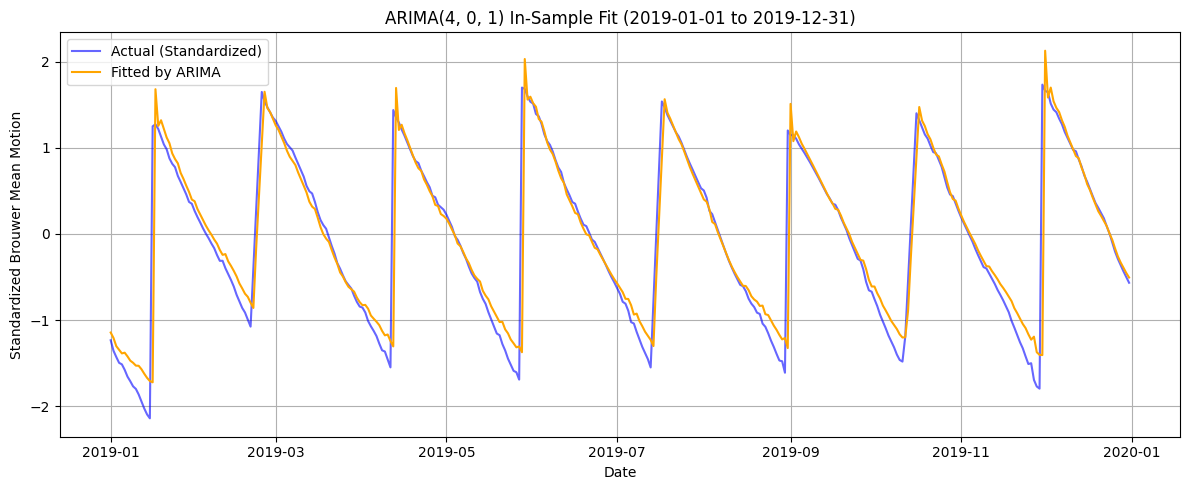

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Step 1: Refit the best ARIMA model on standardized series
model_trad = ARIMA(bmm_standardized, order=best_params)
model_trad_fit = model_trad.fit()

# Step 2: Get in-sample fitted values
fitted_values = model_trad_fit.predict(start=0, end=len(bmm_standardized)-1)

# Step 3: Define time interval
start_date = '2019-01-01'
end_date = '2019-12-31'

# Step 4: Filter both actual and fitted series to the time window
actual_window = bmm_standardized[start_date:end_date]
fitted_window = fitted_values[start_date:end_date]

# Step 5: Plot only the windowed data (y-axis adjusts dynamically)
plt.figure(figsize=(12, 5))
plt.plot(actual_window, label='Actual (Standardized)', color='blue', alpha=0.6)
plt.plot(fitted_window, label='Fitted by ARIMA', color='orange')
plt.title(f'ARIMA{best_params} In-Sample Fit ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Brouwer Mean Motion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


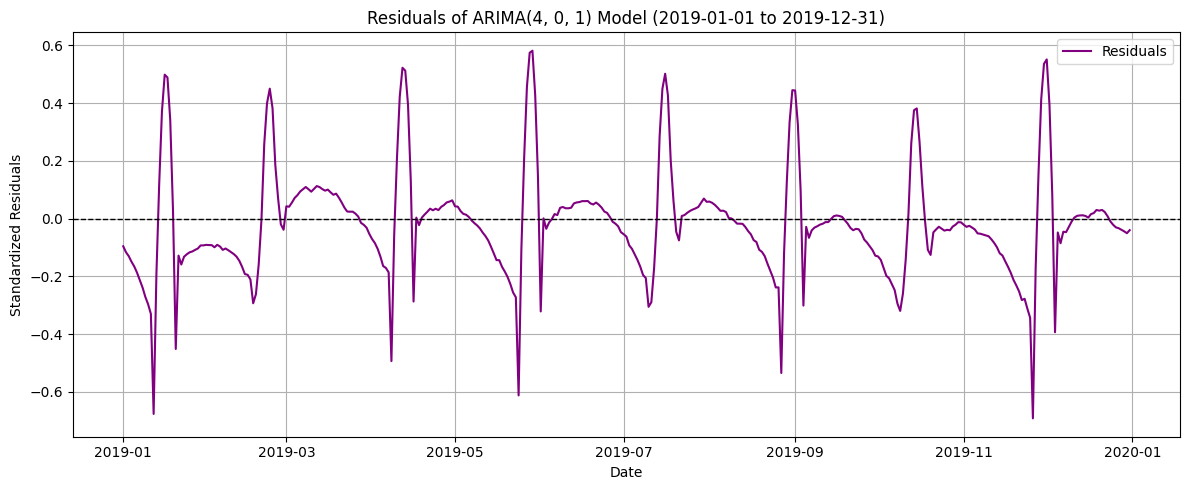

In [ ]:
from scipy.signal import savgol_filter

# Step 1: Get residuals from the best ARIMA model
residuals = model_trad_fit.resid

# Step 2: Smooth the residuals (window length must be odd and < len(data))
smoothed_residuals = pd.Series(
    savgol_filter(residuals, window_length=9, polyorder=2),
    index=residuals.index
)


# Step 2: Define the desired time interval
start_date = '2019-01-01'
end_date = '2019-12-31'

# Step 3: Filter residuals to that time interval
residuals_window = smoothed_residuals[start_date:end_date]

# Step 4: Plot residuals (auto y-axis)
plt.figure(figsize=(12, 5))
plt.plot(residuals_window, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f'Residuals of ARIMA{best_params} Model ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


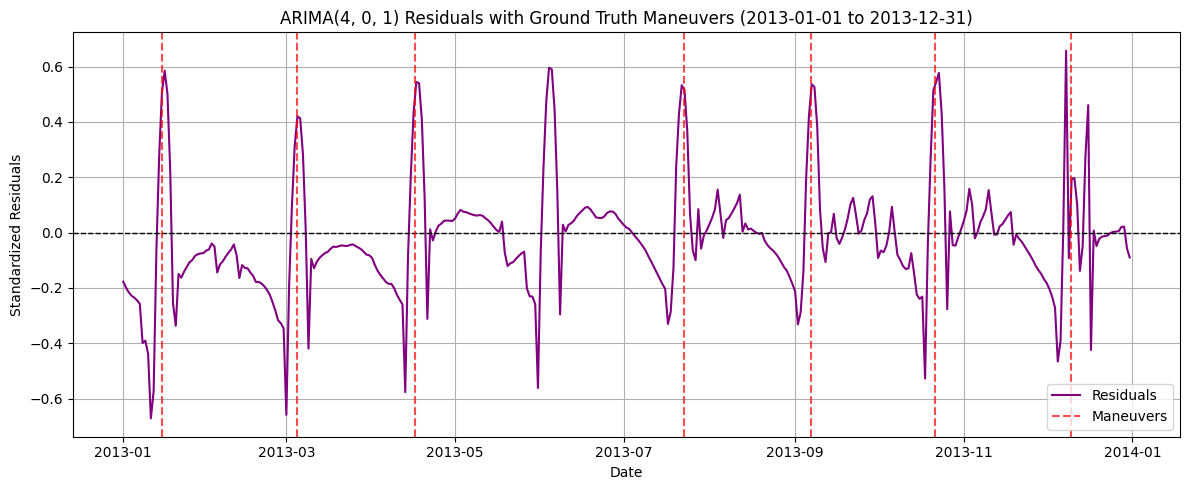

In [ ]:
#Load maneuver ground truth
truth_df = pd.read_excel("/content/manFY2F_cleaned.xlsx")

#Create maneuver timestamps by combining date and time
truth_df["Maneuver_Timestamp"] = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

#Define time window
start_date = '2013-01-01'
end_date = '2013-12-31'

#Filter maneuver timestamps to the defined window
filtered_maneuvers = truth_df[
    (truth_df["Maneuver_Timestamp"] >= start_date) &
    (truth_df["Maneuver_Timestamp"] <= end_date)
]["Maneuver_Timestamp"]


#Get residuals from the best ARIMA model for the same window
residuals_window = smoothed_residuals[start_date:end_date]

# Plot
plt.figure(figsize=(12, 5))
res_line, = plt.plot(residuals_window, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Plot one representative maneuver line for legend
man_line = plt.axvline(x=filtered_maneuvers.iloc[0], color='red', linestyle='--', alpha=0.7, label='Maneuvers')

# Plot the rest (without labels)
for ts in filtered_maneuvers.iloc[1:]:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.7)

# Formatting
plt.title(f'ARIMA{best_params} Residuals with Ground Truth Maneuvers ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# **3.Quantitative Anaysis**

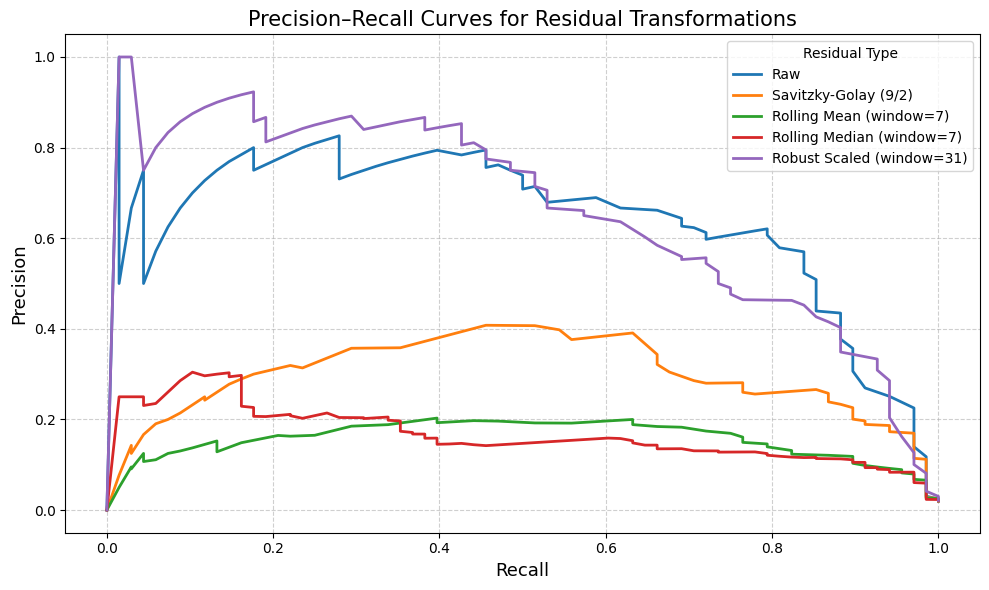


=== ARIMA Residual Evaluation Summary ===


,Residual Type,Optimal Threshold,Precision,Recall,F1,TP,FP,FN,PR AUC
0,Raw,0.872102,0.620690,0.794118,0.696774,54,33,14,0.633365
1,Robust Scaled (window=31),12.061818,0.556818,0.720588,0.628205,49,39,19,0.659639
2,Savitzky-Golay (9/2),0.527960,0.390909,0.632353,0.483146,43,67,25,0.293598
3,Rolling Mean (window=7),0.292681,0.200000,0.632353,0.303887,43,172,25,0.154774
4,Rolling Median (window=7),0.338504,0.205357,0.338235,0.255556,23,89,45,0.165606


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from datetime import timedelta

# --- Utility: Robust rolling MAD ---
def rolling_mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

# --- Detection Function without TN ---
def compute_prf_simple(
    residual_series: pd.Series,
    ground_truth_timestamps: pd.Series,
    threshold: float,
    matching_window_days: float = 3.0
):
    detections = residual_series[residual_series > threshold]
    detection_times = detections.index.sort_values()

    TP, FP, matched_gt = 0, 0, set()
    for det_time in detection_times:
        for i, gt_time in enumerate(ground_truth_timestamps):
            if i in matched_gt:
                continue
            if abs(det_time - gt_time) <= pd.Timedelta(days=matching_window_days):
                TP += 1
                matched_gt.add(i)
                break
        else:
            FP += 1

    FN = len(ground_truth_timestamps) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1, TP, FP, FN

# --- Residual Preparations ---
residuals = model_trad_fit.resid
resid_types = {
    "Raw": residuals.abs(),
    "Savitzky-Golay (9/2)": pd.Series(
        savgol_filter(residuals, window_length=9, polyorder=2),
        index=residuals.index).abs(),
    "Rolling Mean (window=7)": residuals.rolling(window=7, center=True, min_periods=1).mean().abs(),
    "Rolling Median (window=7)": residuals.rolling(window=7, center=True, min_periods=1).median().abs(),
    "Robust Scaled (window=31)": (
        ((residuals - residuals.rolling(window=31, center=True, min_periods=1).median()) /
         (residuals.rolling(window=31, center=True, min_periods=1).apply(rolling_mad, raw=True) + 1e-8)).abs()
    ),
}

# --- Evaluation Loop ---
summary_rows = []
resid_metrics_dfs = {}
matching_window_days = 3.0
series_ground_truth_manoeuvre_timestamps = truth_df["Maneuver_Timestamp"]

plt.figure(figsize=(10, 6))

for name, abs_resid in resid_types.items():
    # Remove zeros and near-zero values using a small quantile cutoff
    abs_resid_clean = abs_resid[abs_resid > abs_resid.quantile(0.01)]

    # Generate thresholds between 1st percentile and max
    thresholds = np.linspace(abs_resid_clean.min(), abs_resid_clean.max(), 150)

    pr_points = []
    metrics = []

    for threshold in thresholds:
        precision, recall, f1, TP, FP, FN = compute_prf_simple(
            abs_resid,
            series_ground_truth_manoeuvre_timestamps,
            threshold,
            matching_window_days=matching_window_days
        )
        pr_points.append((recall, precision))
        metrics.append((threshold, precision, recall, f1, TP, FP, FN))

    metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN"])
    resid_metrics_dfs[name] = metrics_df.copy()

    best_idx = metrics_df["F1"].idxmax()
    best_row = metrics_df.loc[best_idx]

    pr_points_arr = np.array(pr_points)
    sorted_idx = np.argsort(pr_points_arr[:, 0])  # sort by recall
    auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # PR AUC

    summary_rows.append({
        "Residual Type": name,
        "Optimal Threshold": best_row["Threshold"],
        "Precision": best_row["Precision"],
        "Recall": best_row["Recall"],
        "F1": best_row["F1"],
        "TP": int(best_row["TP"]),
        "FP": int(best_row["FP"]),
        "FN": int(best_row["FN"]),
        "PR AUC": auc_pr
    })

    plt.plot(pr_points_arr[:, 0], pr_points_arr[:, 1], label=f"{name}", linewidth=2)

# --- Final PR Plot ---
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision–Recall Curves for Residual Transformations", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Residual Type", fontsize=10)
plt.tight_layout()
plt.show()

# --- Summary Table ---
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("F1", ascending=False).reset_index(drop=True)

from IPython.display import display
print("\n=== ARIMA Residual Evaluation Summary ===")
display(summary_df)
